In [1]:
%load_ext sparksql_magic

# Patient Administrative Outcomes Predictive Model

Data Source: https://physionet.org/content/mimic-iv-fhir/1.0/

HIPAA and Human Subjects Research

- [Methods for De-identification of PHI | Health and Human Services](https://www.hhs.gov/hipaa/for-professionals/special-topics/de-identification/index.html)

**FHIR Resources**
- Patient: For demographic information.
- Encounter: To track patient visits and interactions.
- Condition: For diagnoses and health conditions.
- Procedure: For medical procedures performed.
- Observation: For lab results and vital signs

## 0. Project Init

In [2]:
import os
import pandas as pd
import json
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

spark = SparkSession.builder.appName("FhirDataApplication").getOrCreate()
display(spark)

## 1. Load Datasets

### 1.1 Patient
- `patientID`: Unique identifier for the patient
- `gender`: Gender of the patient (male/female)
- `birthDate`: Birth Date
- `maritalStatus`: Marital Status 

In [3]:
with open("schema/Patient.json") as f:
    schema_read = json.loads(f.read())
schema =  T.StructType.fromJson(schema_read)
df_MimicPatient =  spark.read.schema(schema).json("_dataset/MimicPatient.ndjson")
    
df_MimicPatient.createOrReplaceTempView("df_patient")

In [4]:
fm_patient = spark.sql("""
select 
    id AS patientId,
    gender AS gender,
    to_date(birthDate) birthDate,
    maritalStatus.coding[0].code AS maritalStatus
from df_patient
""")
print('Total Patient:', fm_patient.count())
fm_patient.createOrReplaceTempView("patient")
# fm_patient.toPandas().to_parquet('_dataset/patient.parquet', index=False)
display(fm_patient.toPandas().head(5))

Total Patient: 299712


,patientId,gender,birthDate,maritalStatus
0,c1a51556-8f1b-5ca1-a8b5-ece5e7bb8602,male,2048-07-11,M
1,363f1c3f-87b7-54f9-b22e-d9ed1bc03906,female,2131-12-18,UNK
2,e0461572-bda1-5fc1-9703-607152294019,male,2091-06-06,UNK
3,d16c5811-06c5-5f7f-87d7-fe2adb7bd10c,male,2105-04-05,UNK
4,7458d66f-3fd9-5208-9223-4fdf0bacbfb8,male,2129-02-16,UNK


### 1.2 Encounter

The Encounter is a resource that represents an interaction between a patient and healthcare provider(s) for the purpose of providing healthcare services or assessing the patient's health status.

It records the full span of a hospital stay, including admission, stay and discharge. It includes details such as admission start and end time, context for the admission and patient movements within the hospital.


**Table Attributes**

- `encounterId`: Unique identifier for the encounter.
- `patientId`: Unique identifier for the patient.
- `ref_encounterId`:Reference to a related encounter; can reference both future and past encounters.
- `periodStart`: Start timestamp of the encounter period.
- `periodEnd`:End timestamp of the encounter period.
- `duration`: Total duration of encounter
- `status`: Current status of the encounter (e.g., planned, in-progress, finished).
- `encounterClass`: Classification of the encounter (e.g., inpatient, outpatient); Helps categorize the nature of the healthcare service provided.
- `codedType`: Code representing the specific type of encounter.
- `displayType`: Display name for the type of encounter.
- `systemType`: System from which the type code is derived.
- `priority`: Urgency of the encounter such as routine, urgent, or emergency; 

In [5]:
with open("schema/Encounter.json") as f:
    schema_read = json.loads(f.read())
schema =  T.StructType.fromJson(schema_read)
df_MimicEncounter =  spark.read.schema(schema).json("_dataset/MimicEncounter.ndjson") \
    .withColumn("sourceName", F.split_part(F.input_file_name(), F.lit("/"), F.lit(-1)))

df_MimicEncounterED =  spark.read.schema(schema).json("_dataset/MimicEncounterED.ndjson") \
    .withColumn("sourceName", F.split_part(F.input_file_name(), F.lit("/"), F.lit(-1)))

df_MimicEncounterICU =  spark.read.schema(schema).json("_dataset/MimicEncounterICU.ndjson") \
    .withColumn("sourceName", F.split_part(F.input_file_name(), F.lit("/"), F.lit(-1)))

df_encounter = df_MimicEncounter.union(df_MimicEncounterED).union(df_MimicEncounterICU)
df_encounter.createOrReplaceTempView("df_encounter")

In [6]:
fm_encounter = spark.sql("""
SELECT
    id AS encounterId,
    replace(subject.reference, "Patient/", "") AS patientId,
    replace(partOf.reference, "Encounter/", "") AS ref_encounterId,
    CAST(period.start AS timestamp) periodStart,
    CAST(period.end AS timestamp) periodEnd,
    date_diff(day, periodStart, periodEnd) duration,
    status AS status,
    class.code AS encounterClass,
    -- type[0].coding[0].code AS codedType,
    type[0].coding[0].display AS displayType,
    -- type[0].coding[0].system AS systemType,
    nvl(priority.coding[0].display, 'emergency') AS priority,
    -- Next EncounterID & Readmission Status
    LEAD(id) OVER (PARTITION BY subject.reference ORDER BY period.start) AS nextEncounterId,
    CASE 
        WHEN DATEDIFF(day, period.end, LEAD(period.start) OVER (PARTITION BY subject.reference ORDER BY period.start)) <= 30 THEN 'Readmission'
        ELSE 'No Readmission'
    END AS readmissionStatus,
    sourceName
FROM df_encounter
""")
fm_encounter.createOrReplaceTempView("encounter")
print('Total Encounter:', fm_encounter.count())
# fm_encounter.toPandas().to_parquet('_dataset/encounter.parquet', index=False)
display(fm_encounter.toPandas().head(5))

Total Encounter: 929499


,encounterId,patientId,ref_encounterId,periodStart,periodEnd,duration,status,encounterClass,displayType,priority,nextEncounterId,readmissionStatus,sourceName
0,de339c63-682c-59d3-8e80-ba1e4ecfcb8c,0000d4d1-ca44-5bbb-b183-fb47a16c3c8e,None,2134-06-25 08:28:00,2134-06-25 13:19:00,0,finished,EMER,Patient encounter procedure,emergency,None,No Readmission,MimicEncounterED.ndjson
1,feb85620-d7d8-5a3c-8087-8cafa9e998d2,000b4fd2-f9eb-558f-ab97-914c2e574b64,None,2148-01-15 16:19:00,2148-01-30 01:07:00,14,finished,OBSENC,Patient encounter procedure,routine,5b87595b-7d88-5dc4-8f68-1a21956f6192,No Readmission,MimicEncounter.ndjson
2,5b87595b-7d88-5dc4-8f68-1a21956f6192,000b4fd2-f9eb-558f-ab97-914c2e574b64,None,2148-06-02 07:34:00,2148-06-05 03:13:00,2,finished,EMER,Patient encounter procedure,emergency,None,No Readmission,MimicEncounter.ndjson
3,a77192d1-ae30-57c0-89a8-0b01d09ab01e,000c1aa6-fb89-59c3-a046-696ce7dfbf17,None,2186-12-28 05:41:00,2186-12-28 11:03:00,0,finished,EMER,Patient encounter procedure,emergency,None,No Readmission,MimicEncounterED.ndjson
4,d611386f-89e5-5b05-bd5a-012193be8bb1,0011f027-192d-5fa3-b6e8-3903a96d7e5c,4d6df42b-2343-5c6f-8695-74d8a2e2bc84,2178-12-19 00:08:00,2178-12-19 10:42:00,0,finished,EMER,Patient encounter procedure,emergency,4d6df42b-2343-5c6f-8695-74d8a2e2bc84,Readmission,MimicEncounterED.ndjson


### 1.3 Condition

The Condition resource in FHIR is used to record detailed information about a patient’s health state, including diagnoses, problems, or other clinical concerns. Here are the key points:

- Scope and Usage: It captures conditions that have risen to a level of concern, such as diseases, health issues, or post-procedure states.
- Clinical Context: Conditions can be recorded based on a clinician’s assessment or expressed by the patient or care team members.
- Examples: Conditions like pregnancy, post-surgical states, or chronic illnesses can be documented. It can also include social determinants of health like unemployment or lack of transportation.

Data Preprocessing Condition Code System is both ICD 9 & ICD 10, Standardize ICD-9 and ICD-10 codes to a common standard. GEMs (General Equivalence Mappings) are crosswalks between ICD-9 and ICD-10 codes. They help map codes from ICD-9-CM to ICD-10-CM and vice versa.

https://www.cms.gov/Medicare/Coding/ICD10/Downloads/ICD-10_GEM_fact_sheet.pdf

**Table Attributes**

- `conditionId`: The unique identifier for the condition.
- `patientId`: The unique identifier for the patient.
- `encounterId`: The unique identifier for the encounter.
- `categoryCode`: Condition category.
- `conditionCode`: The code representing the specific condition.
- `conditionDisplay`: The display name for the condition.
- `conditionSystem`: The system from which the condition code is derived.

In [8]:
with open("schema/Condition.json") as f:
    schema_read = json.loads(f.read())
schema =  T.StructType.fromJson(schema_read)
df_MimicCondition =  spark.read.schema(schema).json("_dataset/MimicCondition.ndjson") \
    .withColumn("sourceName", F.split_part(F.input_file_name(), F.lit("/"), F.lit(-1)))

df_MimicConditionED =  spark.read.schema(schema).json("_dataset/MimicConditionED.ndjson") \
    .withColumn("sourceName", F.split_part(F.input_file_name(), F.lit("/"), F.lit(-1)))

df_condition = df_MimicCondition.union(df_MimicConditionED)
df_condition.createOrReplaceTempView("df_condition")

In [9]:
fm_condition = spark.sql("""
SELECT
    id AS conditionId,
    replace(subject.reference, "Patient/", "") AS patientId,
    replace(encounter.reference, "Encounter/", "") AS encounterId,
    category[0].coding[0].code categoryCode,
    code.coding[0].code AS conditionCode,
    code.coding[0].display AS conditionDisplay,
    code.coding[0].system AS conditionSystem,
    sourceName
FROM df_condition
where id is not null -- Remove Corrupt Dataset
""")
fm_condition.createOrReplaceTempView("condition")
print('Total Condition:', fm_condition.count())
# fm_condition.toPandas().to_parquet('_dataset/condition.parquet', index=False)

Total Condition: 5655375


### 1.4 Procedure

The Procedure resource in FHIR is used to record details of current and historical procedures performed on or for a patient.

**Table Attributes**

- `procedureId`: The unique identifier for the procedure.
- `patientId`: The unique identifier for the patient.
- `encounterId`: The unique identifier for the encounter.
- `status`: The current status of the procedure (e.g., completed, in-progress, not-done)
- `performedDateTime`: The date and time when the procedure was performed.
- `procedureCode`: The code representing the specific procedure.
- `procedureDisplay`: The display name for the procedure.
- `procedureSystem`: The system from which the procedure code is derived.

In [10]:
with open("schema/Procedure.json") as f:
    schema_read = json.loads(f.read())
schema =  T.StructType.fromJson(schema_read)
df_MimicProcedure =  spark.read.schema(schema).json("_dataset/MimicProcedure.ndjson") \
    .withColumn("sourceName", F.split_part(F.input_file_name(), F.lit("/"), F.lit(-1)))

df_MimicProcedureED =  spark.read.schema(schema).json("_dataset/MimicProcedureED.ndjson") \
    .withColumn("sourceName", F.split_part(F.input_file_name(), F.lit("/"), F.lit(-1)))

df_MimicProcedureICU =  spark.read.schema(schema).json("_dataset/MimicProcedureICU.ndjson") \
    .withColumn("sourceName", F.split_part(F.input_file_name(), F.lit("/"), F.lit(-1)))

df_procedure = df_MimicProcedure.union(df_MimicProcedureED).union(df_MimicProcedureICU)
df_procedure.createOrReplaceTempView("df_procedure")

In [11]:
fm_procedure = spark.sql("""
SELECT
    id AS procedureId,
    replace(subject.reference, "Patient/", "") AS patientId,
    replace(encounter.reference, "Encounter/", "") AS encounterId,
    status AS status,
    nvl(to_date(performedDateTime), to_date(performedPeriod.start)) AS performedDateTime,
    code.coding[0].code AS procedureCode,
    code.coding[0].display AS procedureDisplay,
    code.coding[0].system AS procedureSystem,
    sourceName
FROM df_procedure
""")
fm_procedure.createOrReplaceTempView("procedure")
print('Total Procedure:', fm_procedure.count())
# fm_procedure.toPandas().to_parquet('_dataset/procedure.parquet', index=False)

Total Procedure: 3354975


## 2. Exploratory Data Analysis

### 2.1. Patient

#### BirthYear Distribution Line Chart

In [11]:
patient_birthYear_df = spark.sql("select date_format(birthDate, 'yyyy') birthYear, count(*) count  from patient group by 1 order by 1").toPandas()

fig = px.line(
    patient_birthYear_df, 
    x='birthYear', 
    y='count', 
    title='Patient BirthYear Distribution [De-Identified]'
)

fig.update_layout(
    xaxis_title='Birth Year',
    yaxis_title='Number of Patients',
    template='plotly_white'  
)
fig.show()

#### Gender Distribution Pie Chart

In [12]:
gender_count_df = fm_patient.groupBy("gender").count()
fig_patient_gender = px.pie(gender_count_df.toPandas(), values='count', names='gender', title='Gender Distribution')
fig_patient_gender.show()

#### Gender & Marital Status Grouped Bar Chart

In [13]:
gender_marital_status_count_df = fm_patient.groupBy("gender", "maritalStatus").count()
fig_patient_gender_marital_status = px.bar(
    gender_marital_status_count_df.toPandas(), 
    x='maritalStatus', 
    y='count', 
    color='gender', 
    title='Count by Gender and Marital Status', 
    barmode='group'
)
fig_patient_gender_marital_status.show()

### 2.2. Encounter

#### Encounter Year Distribution Line Chart

In [14]:
encounter_year_df = spark.sql("select date_format(periodStart, 'yyyy') encounterYear, count(*) count  from encounter group by 1 order by 1").toPandas()

fig = px.line(
    encounter_year_df, 
    x='encounterYear', 
    y='count', 
    title='Encounter Period Year Distribution [De-Identified]'
)

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Encounters',
    template='plotly_white'  
)
fig.show()

#### Source Distribution Pie Chart

In [15]:
px.pie(fm_encounter.groupBy("sourceName").count().toPandas(), values='count', names='sourceName', title='Source Distribution').show()

#### Encounter Class Distribution Pie Chart

In [16]:
px.pie(fm_encounter.groupBy("encounterClass").count().toPandas(), values='count', names='encounterClass', title='Encounter Class Distribution').show()

#### Encounter Priority Distribution Pie Chart

In [17]:
px.pie(fm_encounter.groupBy("priority").count().toPandas(), values='count', names='priority', title='Encounter Priority Distribution').show()

#### Encounter Class by Priority Grouped Bar Chart

In [18]:
grouped_data = fm_encounter.groupBy("encounterClass", "priority").count().toPandas()

fig = px.bar(
    grouped_data, 
    x='priority', 
    y='count', 
    color='encounterClass', 
    title='Encounter Class by Priority', 
    labels={'count': 'Count'},
    barmode='group'
)

fig.update_layout(xaxis_title='Priority',yaxis_title='Count',legend_title='Encounter Class')

fig.show()

#### Patient Readmission Pie Chart

In [19]:
px.pie(fm_encounter.groupBy("readmissionStatus").count().toPandas(), values='count', names='readmissionStatus', title='Patient Readmission').show()

#### Encounter Over the Years by ReadmissionStatus

In [20]:
readmission_df = fm_encounter.groupBy(
    "readmissionStatus", F.date_format("periodStart", "yyyy").alias("year")
).count().orderBy("year")

fig = px.line(readmission_df.toPandas(), 
              x='year', 
              y='count', 
              color='readmissionStatus',  # Differentiate lines by readmissionStatus
              title='Encounter Over the Years by ReadmissionStatus', 
              labels={'year': 'Year', 'count': 'Number of Encounters'})

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Encounters',
    legend_title='Readmission Status',
    template='plotly_white'  
)
fig.show()

#### Readmission Encounters: Priority Transitions Sankey Diagram

In [21]:
priority_encounter_df = spark.sql("""
SELECT
    e1.priority priority1,
    e2.priority priority2,
    count(*) count
FROM encounter e1
JOIN encounter e2
ON e1.nextEncounterId = e2.encounterID
WHERE e1.readmissionStatus == 'Readmission'
GROUP BY all
ORDER by 3 desc
""")

priority_encounter_pd = priority_encounter_df.toPandas()
all_priorities = list(set(priority_encounter_pd['priority1'].tolist() + 
                          priority_encounter_pd['priority2'].tolist()))
node_map = {priority: idx for idx, priority in enumerate(all_priorities)}
priority_encounter_pd['source'] = priority_encounter_pd['priority1'].map(node_map)
priority_encounter_pd['target'] = priority_encounter_pd['priority2'].map(node_map)

table_trace = go.Table(
    header=dict(values=["Priority 1", "Priority 2", "Count"], fill_color='lightgrey', align='center'),
    cells=dict(values=[priority_encounter_pd['priority1'], priority_encounter_pd['priority2'], priority_encounter_pd['count']],
               fill_color='white', align='center')
)

sankey_trace = go.Sankey(
    node=dict(
        pad=15,  # Padding between nodes
        thickness=20,  # Node thickness
        line=dict(color="black", width=0.5),  # Node border settings
        label=all_priorities  # Node labels
    ),
    link=dict(
        source=priority_encounter_pd['source'],  # Source nodes (indices)
        target=priority_encounter_pd['target'],  # Target nodes (indices)
        value=priority_encounter_pd['count']     # Flow values (counts)
    )
)

fig = make_subplots(
    rows=1, cols=2, 
    column_widths=[0.7, 0.3],  # Adjust column widths (30% table, 70% Sankey)
    specs=[[{"type": "table"}, {"type": "sankey"}]],  # Specify types for each subplot
)


fig.add_trace(sankey_trace, row=1, col=1)
fig.add_trace(table_trace, row=1, col=2)

fig.update_layout(
    title_text="Readmission Encounters: Priority Transitions Sankey Diagram and Table",
    font_size=12,
    height=500
)
fig.show()

#### Encounter Count by Source and Duration Group

In [22]:
%%sparksql --l 100
SELECT 
    sourceName, 
    CASE 
        WHEN duration BETWEEN 0 AND 5 THEN '0 to 5 days'
        WHEN duration BETWEEN 6 AND 10 THEN '6 to 10 days'
        WHEN duration BETWEEN 11 AND 20 THEN '11 to 20 days'
        WHEN duration BETWEEN 21 AND 30 THEN '21 to 30 days'
        WHEN duration BETWEEN 31 AND 50 THEN '31 to 50 days'
        WHEN duration BETWEEN 51 AND 100 THEN '51 to 100 days'
        WHEN duration BETWEEN 101 AND 150 THEN '101 to 150 days'
        WHEN duration BETWEEN 151 AND 200 THEN '151 to 200 days'
        WHEN duration BETWEEN 201 AND 250 THEN '201 to 250 days'
        WHEN duration BETWEEN 251 AND 300 THEN '251 to 300 days'
        ELSE 'More than 300 days'
    END AS duration_group,
    COUNT(*) AS encounter_count
FROM encounter
GROUP BY sourceName, duration_group
ORDER BY sourceName, double(split_part(duration_group, ' ', 1));

sourceName,duration_group,encounter_count
MimicEncounter.ndjson,0 to 5 days,341477
MimicEncounter.ndjson,6 to 10 days,55780
MimicEncounter.ndjson,11 to 20 days,23644
MimicEncounter.ndjson,21 to 30 days,5996
MimicEncounter.ndjson,31 to 50 days,3176
MimicEncounter.ndjson,51 to 100 days,1012
MimicEncounter.ndjson,101 to 150 days,111
MimicEncounter.ndjson,151 to 200 days,24
MimicEncounter.ndjson,201 to 250 days,10
MimicEncounter.ndjson,251 to 300 days,1


In [23]:
encounter_duration_df = spark.sql("""SELECT 
    sourceName,
    duration AS duration_group,
    COUNT(*) AS encounter_count
FROM encounter
where duration BETWEEN 1 AND 30
GROUP BY sourceName, duration_group
ORDER BY sourceName, duration_group;""").toPandas()

px.line(encounter_duration_df, x='duration_group', y='encounter_count', color='sourceName',
              markers=True, title="Encounter Count by Source and Duration Group").show()

### 2.3. Condition

In [24]:
%%sparksql
select * from condition limit 3

conditionId,patientId,encounterId,categoryCode,conditionCode,conditionDisplay,conditionSystem,sourceName
10ce1ed4-c6cc-59b7-99b3-f16d355642c3,00000027-c5e0-554f-8e85-b097c3b177d4,c8816dcb-47f0-55f0-933f-122d0caac629,encounter-diagnosis,7455,Ostium secundum type atrial septal defect,http://mimic.mit.edu/fhir/mimic/CodeSystem/mimic-diagnosis-icd9,MimicCondition.ndjson
2aedfdd4-5f41-50bb-94a3-2e39825384c2,00000027-c5e0-554f-8e85-b097c3b177d4,c8816dcb-47f0-55f0-933f-122d0caac629,encounter-diagnosis,53081,Esophageal reflux,http://mimic.mit.edu/fhir/mimic/CodeSystem/mimic-diagnosis-icd9,MimicCondition.ndjson
250944ab-186c-5413-8ccb-0541d7ede098,00000027-c5e0-554f-8e85-b097c3b177d4,c8816dcb-47f0-55f0-933f-122d0caac629,encounter-diagnosis,V1389,Personal history of other specified diseases,http://mimic.mit.edu/fhir/mimic/CodeSystem/mimic-diagnosis-icd9,MimicCondition.ndjson


### 2.4. Procedure

In [25]:
%%sparksql
select * from procedure limit 3

procedureId,patientId,encounterId,status,performedDateTime,procedureCode,procedureDisplay,procedureSystem,sourceName
06572895-c093-5678-a2ee-52025f3fe961,00000027-c5e0-554f-8e85-b097c3b177d4,c8816dcb-47f0-55f0-933f-122d0caac629,completed,2140-01-06,3615,Single internal mammary-coronary artery bypass,http://mimic.mit.edu/fhir/mimic/CodeSystem/mimic-procedure-icd9,MimicProcedure.ndjson
18346b99-0966-5d74-ae19-9b2b86d9a184,00000027-c5e0-554f-8e85-b097c3b177d4,c8816dcb-47f0-55f0-933f-122d0caac629,completed,2140-01-06,3961,Extracorporeal circulation auxiliary to open heart surgery,http://mimic.mit.edu/fhir/mimic/CodeSystem/mimic-procedure-icd9,MimicProcedure.ndjson
ca291152-7892-53ed-b596-79a7bb79a001,00000027-c5e0-554f-8e85-b097c3b177d4,c8816dcb-47f0-55f0-933f-122d0caac629,completed,2140-01-06,3571,Other and unspecified repair of atrial septal defect,http://mimic.mit.edu/fhir/mimic/CodeSystem/mimic-procedure-icd9,MimicProcedure.ndjson


## 3. Data Preparation 

### 3.1. Pivot Condition Table

In [5]:
condition_pivot_df = spark.sql("""
    WITH RankedConditions AS (
        SELECT 
            patientId,
            encounterId,
            conditionDisplay,
            COUNT(*) AS conditionCount,
            ROW_NUMBER() OVER (PARTITION BY encounterId ORDER BY COUNT(*) DESC) AS rank
        FROM condition
        GROUP BY patientId, encounterId, conditionDisplay
    )
    SELECT
        patientId,
        encounterId,
        MAX(CASE WHEN rank = 1 THEN conditionDisplay END) AS condition_1,
        -- MAX(CASE WHEN rank = 1 THEN conditionCount END) AS condition_count_1,
        MAX(CASE WHEN rank = 2 THEN conditionDisplay END) AS condition_2,
        -- MAX(CASE WHEN rank = 2 THEN conditionCount END) AS condition_count_2,
        MAX(CASE WHEN rank = 3 THEN conditionDisplay END) AS condition_3
        -- MAX(CASE WHEN rank = 3 THEN conditionCount END) AS condition_count_3
    FROM RankedConditions
    GROUP BY patientId, encounterId
""").toPandas()
# condition_pivot_df.to_parquet('_dataset/PivotCondition.parquet', index=False)

### 3.2. Pivot Procedure Table

In [6]:
procedure_pivot_df = spark.sql("""
    WITH RankedProcedures AS (
        SELECT 
            patientId,
            encounterId,
            procedureDisplay,
            COUNT(*) AS procedureCount,
            ROW_NUMBER() OVER (PARTITION BY encounterId ORDER BY COUNT(*) DESC) AS rank
        FROM procedure
        GROUP BY patientId, encounterId, procedureDisplay
    )
    SELECT
        patientId,
        encounterId,
        MAX(CASE WHEN rank = 1 THEN procedureDisplay END) AS procedure_1,
        -- MAX(CASE WHEN rank = 1 THEN procedureCount END) AS procedure_count_1,
        MAX(CASE WHEN rank = 2 THEN procedureDisplay END) AS procedure_2,
        -- MAX(CASE WHEN rank = 2 THEN procedureCount END) AS procedure_count_2,
        MAX(CASE WHEN rank = 3 THEN procedureDisplay END) AS procedure_3
        -- MAX(CASE WHEN rank = 3 THEN procedureCount END) AS procedure_count_3
    FROM RankedProcedures
    GROUP BY patientId, encounterId
""").toPandas()
# procedure_pivot_df.to_parquet('_dataset/PivotProcedure.parquet', index=False)

### 3.3. Consolidate Encounter

In [22]:
COPY (
    SELECT
        encounter.encounterId,
        encounter.patientId,
        patient.gender,
        CASE 
            WHEN date_diff('year', patient.birthDate,encounter.periodStart) BETWEEN 18 AND 29 THEN 'young adults'
            WHEN date_diff('year', patient.birthDate,encounter.periodStart) BETWEEN 30 AND 39 THEN 'young adulthood'
            WHEN date_diff('year', patient.birthDate,encounter.periodStart) BETWEEN 40 AND 49 THEN 'early-middle age'
            WHEN date_diff('year', patient.birthDate,encounter.periodStart) BETWEEN 50 AND 59 THEN 'late-middle age'
            WHEN date_diff('year', patient.birthDate,encounter.periodStart) BETWEEN 60 AND 69 THEN 'mid-old age'
            WHEN date_diff('year', patient.birthDate,encounter.periodStart) BETWEEN 70 AND 79 THEN 'senior-old age'
            WHEN date_diff('year', patient.birthDate,encounter.periodStart) BETWEEN 80 AND 89 THEN 'very senior-old'
            WHEN date_diff('year', patient.birthDate,encounter.periodStart) BETWEEN 90 AND 115 THEN 'centenarians'
            ELSE 'other age groups'
        END AS ageGroup,
        patient.maritalStatus,
        encounter.duration encounterDuration,
        encounter.status encounterStatus,
        encounter.encounterClass,
        encounter.displayType encounterType,
        encounter.priority,
        -- Conditions
        condition.condition_1,
        condition.condition_2,
        condition.condition_3,
        -- Procedures
        procedure.procedure_1,
        procedure.procedure_2,
        procedure.procedure_3,
        encounter.readmissionStatus,
        encounter.sourceName
    FROM read_parquet("_dataset/encounter.parquet") encounter
    LEFT JOIN read_parquet("_dataset/patient.parquet") patient
        ON encounter.patientId = patient.patientID
    LEFT JOIN read_parquet("_dataset/PivotCondition.parquet") condition
        ON encounter.encounterId = condition.encounterId
        AND encounter.patientID = condition.patientID
    LEFT JOIN read_parquet("_dataset/PivotProcedure.parquet") procedure
        ON encounter.encounterId = procedure.encounterId
        AND encounter.patientID = procedure.patientID
)
TO '_dataset/ConsolidatedEncounter.parquet'
(FORMAT 'parquet');

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Count
0,929499


## 4. Model Training

Data Source: `_dataset/ConsolidatedEncounter.parquet`

- `encounterId`: Unique Identifier for the Encounter
- `patientId`: Patient Unique Identifier
- `gender`: Patient Gender
- `ageGroup`: Patient Age Group
- `maritalStatus`: Patient Marital Status
- `encounterDuration`: Total Encounter Duration in days
- `encounterStatus`: Current status of the encounter (e.g., planned, in-progress, finished).
- `encounterClass`: Classification of the encounter (e.g., inpatient, outpatient); Helps categorize the nature of the healthcare service provided.
- `encounterType`: Specific type of Encounter
- `priority`: Urgency of the encounter such as routine, urgent, or emergency; 
- `condition_1`: Primary Condition
- `condition_2`: Secondary Condition
- `condition_3`: Other Condition
- `procedure_1`: Primary Procedure
- `procedure_2`: Secondary Procedure
- `procedure_3`: Other Procedure
- `readmissionStatus`: Is the Encounter Readmitted in the Future
- `sourceName`: Source of the Encounter

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [114]:
df = pd.read_parquet("_dataset/ConsolidatedEncounter.parquet")
df.head(10)

,encounterId,patientId,gender,ageGroup,maritalStatus,encounterDuration,encounterStatus,encounterClass,encounterType,priority,condition_1,condition_2,condition_3,procedure_1,procedure_2,procedure_3,readmissionStatus,sourceName
0,de339c63-682c-59d3-8e80-ba1e4ecfcb8c,0000d4d1-ca44-5bbb-b183-fb47a16c3c8e,male,late-middle age,UNK,0,finished,EMER,Patient encounter procedure,emergency,"Dyspnea, unspecified","Pure hypercholesterolemia, unspecified",None,Taking patient vital signs assessment (procedure),Triage: emergency center (procedure),None,No Readmission,MimicEncounterED.ndjson
1,5b87595b-7d88-5dc4-8f68-1a21956f6192,000b4fd2-f9eb-558f-ab97-914c2e574b64,male,mid-old age,S,2,finished,EMER,Patient encounter procedure,emergency,Unspecified essential hypertension,"Epilepsy, unspecified, without mention of intr...","Unspecified schizophrenia, unspecified",Fusion or refusion of 2-3 vertebrae,Excision of intervertebral disc,"Excision of bone for graft, other bones",No Readmission,MimicEncounter.ndjson
2,d611386f-89e5-5b05-bd5a-012193be8bb1,0011f027-192d-5fa3-b6e8-3903a96d7e5c,female,young adults,S,0,finished,EMER,Patient encounter procedure,emergency,ABDOMINAL PAIN RLQ,None,None,Taking patient vital signs assessment (procedure),Triage: emergency center (procedure),None,Readmission,MimicEncounterED.ndjson
3,e05a5017-0027-5277-9fd9-708fdef1f08e,0011f027-192d-5fa3-b6e8-3903a96d7e5c,female,young adults,S,0,finished,EMER,Patient encounter procedure,emergency,"Contusion of right elbow, initial encounter",Contusion of right thumb without damage to nai...,Fall same lev from slip/trip w/o strike agains...,Triage: emergency center (procedure),Taking patient vital signs assessment (procedure),None,No Readmission,MimicEncounterED.ndjson
4,45bd8c0d-6db8-57f5-aa0a-03908471ea35,00142a7d-e5cb-566a-93e8-65dacbbdc20e,female,young adults,S,1,finished,EMER,Patient encounter procedure,emergency,Unspecified episodic mood disorder,"Opioid type dependence, unspecified",Family disruption,Drug detoxification,None,None,Readmission,MimicEncounter.ndjson
5,856559af-b995-533b-95d5-2a0595543185,00142a7d-e5cb-566a-93e8-65dacbbdc20e,female,young adults,S,1,finished,EMER,Patient encounter procedure,emergency,"Urinary tract infection, site not specified",Generalized pain,"Opioid type dependence, continuous",Injection or infusion of other therapeutic or ...,None,None,No Readmission,MimicEncounter.ndjson
6,9fa0a1e6-3217-53a1-a750-ccc638e43a84,00142a7d-e5cb-566a-93e8-65dacbbdc20e,female,young adults,S,3,finished,EMER,Patient encounter procedure,emergency,Dysthymic disorder,Tobacco use disorder,Other B-complex deficiencies,Transfusion of packed cells,None,None,Readmission,MimicEncounter.ndjson
7,b1783037-42d5-5bc3-b5e2-3d0b49e05c39,00142a7d-e5cb-566a-93e8-65dacbbdc20e,female,young adults,S,0,finished,OBSENC,Hospital observation services,routine,Hb-SS disease with crisis,"Abdominal pain, other specified site",Pain in limb,"Routine chest x-ray, so described",Other nonoperative respiratory measurements,None,No Readmission,MimicEncounter.ndjson
8,a9e93c3c-57b3-5aec-b94f-6012246a70dc,00142a7d-e5cb-566a-93e8-65dacbbdc20e,female,young adults,S,0,finished,OBSENC,Hospital observation services,routine,Other and unspecified ovarian cyst,"Depressive disorder, not elsewhere classified","Abdominal pain, left lower quadrant",Other diagnostic ultrasound,Other nonoperative respiratory measurements,"Routine chest x-ray, so described",No Readmission,MimicEncounter.ndjson
9,f54f8db1-7373-575c-979f-990c261777b4,00142a7d-e5cb-566a-93e8-65dacbbdc20e,female,young adults,S,0,finished,OBSENC,Hospital observation services,routine,"Depressive disorder, not elsewhere classified",Generalized pain,"Pain in joint, lower leg",Other nonoperative respiratory measurements,"Routine chest x-ray, so described",None,Readmission,MimicEncounter.ndjson


In [99]:
df['gender'] = df['gender'].astype('category')
df['ageGroup'] = df['ageGroup'].astype('category')
df['maritalStatus'] = df['maritalStatus'].astype('category')

df['encounterStatus'] = df['encounterStatus'].astype('category')
df['encounterClass'] = df['encounterClass'].astype('category')
df['encounterType'] = df['encounterType'].astype('category')
df['priority'] = df['priority'].astype('category')
df['encounterStatus'] = df['encounterStatus'].astype('category')


df['condition_1'] = df['condition_1'].astype('category')
df['condition_2'] = df['condition_2'].astype('category')
df['condition_3'] = df['condition_3'].astype('category')

df['procedure_1'] = df['procedure_1'].astype('category')
df['procedure_2'] = df['procedure_2'].astype('category')
df['procedure_3'] = df['procedure_3'].astype('category')

df['readmissionStatus'] = df['readmissionStatus'].astype('category')

In [100]:
df.columns

Index(['encounterId', 'patientId', 'gender', 'ageGroup', 'maritalStatus',
       'encounterDuration', 'encounterStatus', 'encounterClass',
       'encounterType', 'priority', 'condition_1', 'condition_2',
       'condition_3', 'procedure_1', 'procedure_2', 'procedure_3',
       'readmissionStatus', 'sourceName'],
      dtype='object')

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929499 entries, 0 to 929498
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   encounterId        929499 non-null  object  
 1   patientId          929499 non-null  object  
 2   gender             929499 non-null  category
 3   ageGroup           929499 non-null  category
 4   maritalStatus      929499 non-null  category
 5   encounterDuration  929499 non-null  int64   
 6   encounterStatus    929499 non-null  category
 7   encounterClass     929499 non-null  category
 8   encounterType      929499 non-null  category
 9   priority           929499 non-null  category
 10  condition_1        854841 non-null  category
 11  condition_2        674369 non-null  category
 12  condition_3        525436 non-null  category
 13  procedure_1        727243 non-null  category
 14  procedure_2        619203 non-null  category
 15  procedure_3        148493 non-null

In [102]:
# Checking the unique values in the dataset
df.nunique()

encounterId          929499
patientId            263457
gender                    2
ageGroup                  8
maritalStatus             5
encounterDuration       168
encounterStatus           1
encounterClass            5
encounterType            55
priority                  4
condition_1           20258
condition_2           19224
condition_3           17306
procedure_1            8154
procedure_2            7366
procedure_3            6226
readmissionStatus         2
sourceName                3
dtype: int64

In [103]:
# Checking the null value
df.isnull().sum()

encounterId               0
patientId                 0
gender                    0
ageGroup                  0
maritalStatus             0
encounterDuration         0
encounterStatus           0
encounterClass            0
encounterType             0
priority                  0
condition_1           74658
condition_2          255130
condition_3          404063
procedure_1          202256
procedure_2          310296
procedure_3          781006
readmissionStatus         0
sourceName                0
dtype: int64

In [104]:
# Checking the duplicate values
df.duplicated().sum()

0

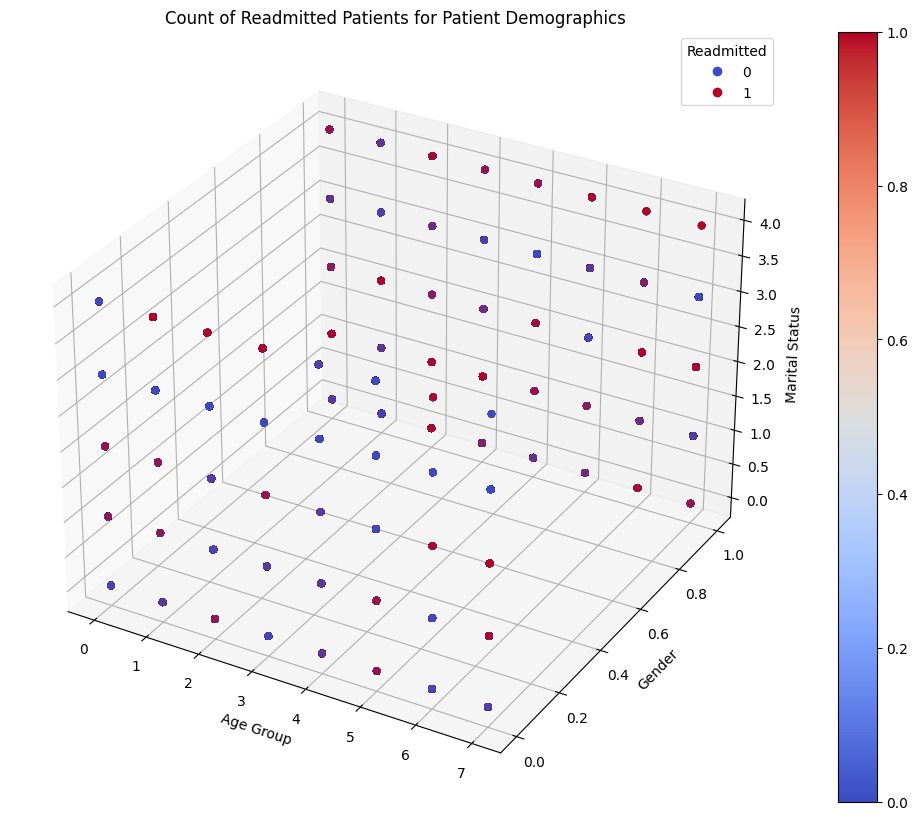

In [70]:
es = df['readmissionStatus'].map({'Readmission': 1, 'No Readmission': 0})

x = df['ageGroup'].cat.codes
y = df['gender'].cat.codes
z = df['maritalStatus'].cat.codes

c = es
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(x, y, z, c=c, cmap='coolwarm', marker='o')
fig.colorbar(img)

ax.set_xlabel('Age Group')
ax.set_ylabel('Gender')
ax.set_zlabel('Marital Status')

plt.title('Count of Readmitted Patients for Patient Demographics')
plt.legend(*img.legend_elements(), title='Readmitted')
plt.show()

### 4.1. LabelEncoder 

Convert categorical string labels (or values) into numeric labels. This is often required for machine learning algorithms that expect numerical input rather than categorical text data.

In [105]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()
# Apply the LabelEncoder to the categorical columns
df['gender'] = le.fit_transform(df['gender'])
df['ageGroup'] = le.fit_transform(df['ageGroup'])
df['maritalStatus'] = le.fit_transform(df['maritalStatus'])
df['encounterStatus'] = le.fit_transform(df['encounterStatus'])
df['encounterClass'] = le.fit_transform(df['encounterClass'])
df['encounterType'] = le.fit_transform(df['encounterType'])
df['encounterStatus'] = le.fit_transform(df['encounterStatus'])
df['priority'] = le.fit_transform(df['priority'])
df['condition_1'] = le.fit_transform(df['condition_1'])
df['condition_2'] = le.fit_transform(df['condition_2'])
df['condition_3'] = le.fit_transform(df['condition_3'])
df['procedure_1'] = le.fit_transform(df['procedure_1'])
df['procedure_2'] = le.fit_transform(df['procedure_2'])
df['procedure_3'] = le.fit_transform(df['procedure_3'])
df['readmissionStatus'] = le.fit_transform(df['readmissionStatus'])

df.head(3)

,encounterId,patientId,gender,ageGroup,maritalStatus,encounterDuration,encounterStatus,encounterClass,encounterType,priority,condition_1,condition_2,condition_3,procedure_1,procedure_2,procedure_3,readmissionStatus,sourceName
0,de339c63-682c-59d3-8e80-ba1e4ecfcb8c,0000d4d1-ca44-5bbb-b183-fb47a16c3c8e,1,2,3,0,0,2,34,1,6498,15883,17306,7851,7257,6226,0,MimicEncounterED.ndjson
1,5b87595b-7d88-5dc4-8f68-1a21956f6192,000b4fd2-f9eb-558f-ab97-914c2e574b64,1,3,2,2,0,2,34,1,19490,6504,16936,3865,2662,2161,0,MimicEncounter.ndjson
2,d611386f-89e5-5b05-bd5a-012193be8bb1,0011f027-192d-5fa3-b6e8-3903a96d7e5c,0,7,2,0,0,2,34,1,105,19224,17306,7851,7257,6226,1,MimicEncounterED.ndjson


In [106]:
df.drop(columns='encounterId', inplace=True)
df.drop(columns='patientId', inplace=True)
df.drop(columns='sourceName', inplace=True)

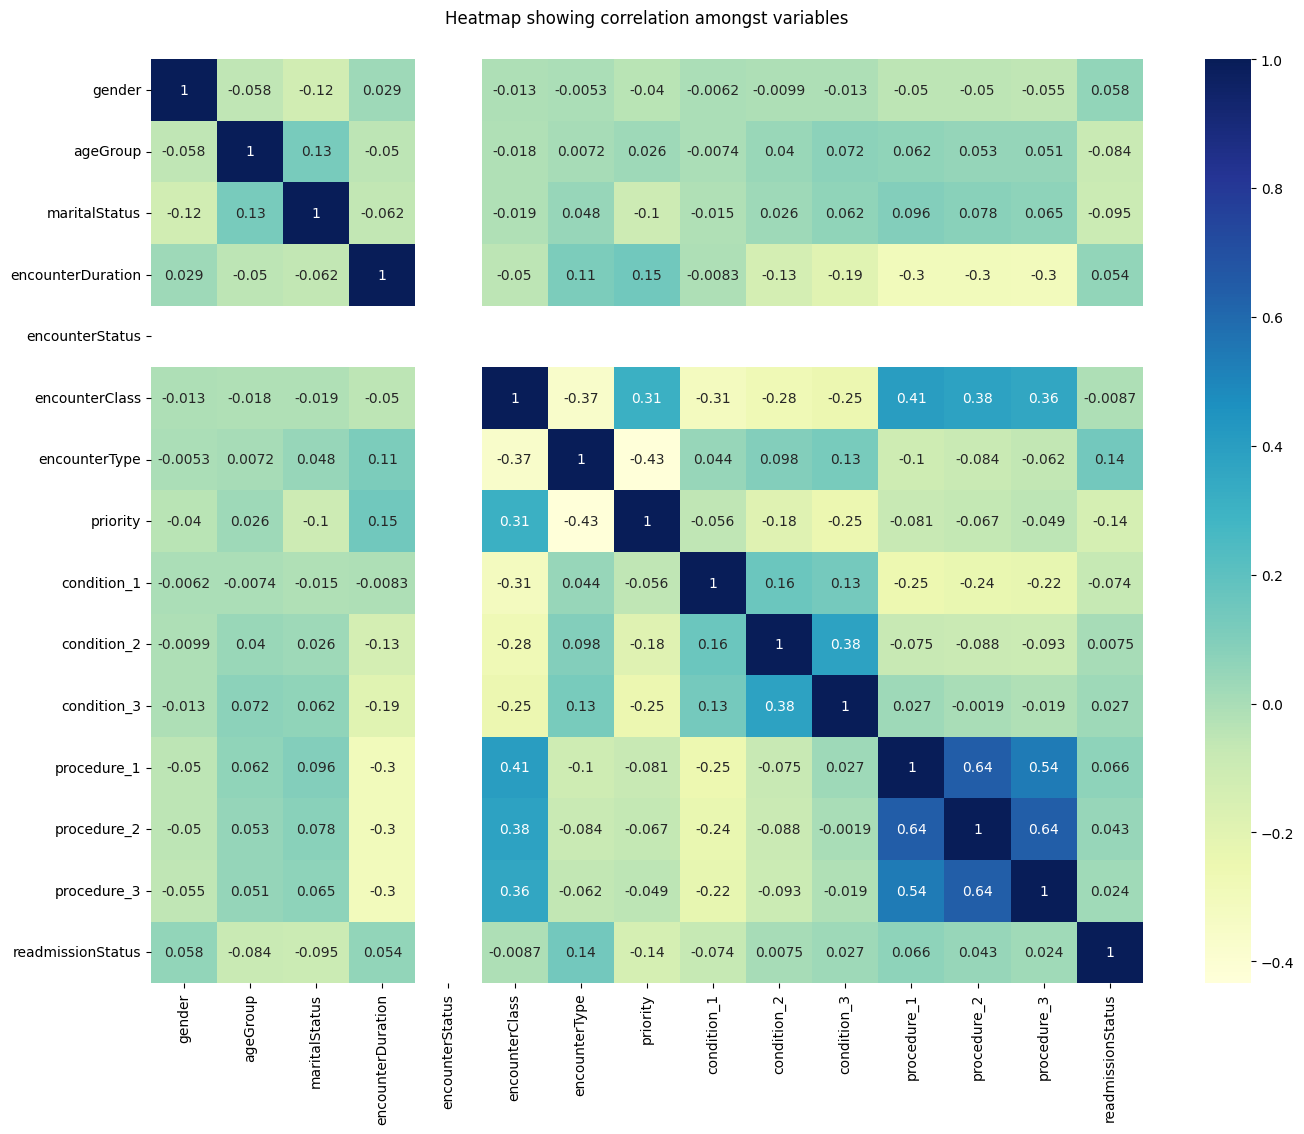

In [107]:
# Show correlation of numerical columns
df_numeric = df.select_dtypes(include=['number'])

# Calculate correlation matrix between selected columns
correlation_matrix = df_numeric.corr()

# Visualizing correlation between variables
plt.figure(figsize=(16,12))
sns.heatmap(correlation_matrix, cmap='YlGnBu', fmt='.2g', annot=True)

plt.title('Heatmap showing correlation amongst variables',y=1.03)
plt.show()

### 4.2. Split Train and Test Dataset

In [108]:
from sklearn.model_selection import train_test_split

In [109]:
# Split the data into two DataFrames: X (features) and y (target variable)
X = df.drop(columns=['readmissionStatus'],axis=1)  # Specify at least one column as a feature
y = df["readmissionStatus"]  # Specify one column as the target variable

# Split the data into train and test subsets
# You can adjust the test size and random state
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.275, random_state=123
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((673886, 14), (255613, 14), (673886,), (255613,))

### 4.3. Random Forest Classifer

In [110]:
from sklearn.ensemble import RandomForestClassifier

In [111]:
# Define parameters: these will need to be tuned to prevent overfitting and underfitting
params = {
    "n_estimators": 97,  # Number of trees in the forest
    "max_depth": 10,  # Max depth of the tree
    "min_samples_split": 3,  # Min number of samples required to split a node
    "min_samples_leaf": 1,  # Min number of samples required at a leaf node
    "ccp_alpha": 0,  # Cost complexity parameter for pruning
    "random_state": 123,
}
#{'n_estimators': 97, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 10, 'ccp_alpha': 0}

# Create a RandomForestRegressor object with the parameters above
rf = RandomForestClassifier(**params)

# Train the random forest on the train set
rf = rf.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = rf.predict(X_test)

In [112]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [113]:
y_pred = rf.predict(X_test)
print('Training Set:', rf.score(X_train,y_train))
print('Test Set:', rf.score(X_test,y_test))

# Calculate the accuracy, precision, and recall scores
print("Accuracy:", "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precision:", "{:.2f}%".format(precision_score(y_test, y_pred)*100))
print("Recall:", "{:.2f}%".format(recall_score(y_test, y_pred)*100))
print("Area Under the Curve:", "{:.2f}%".format(roc_auc_score(y_test, y_pred)*100))

Training Set: 0.7425439911201598
Test Set: 0.7400992907246502
Accuracy: 74.01%
Precision: 72.85%
Recall: 64.95%
Area Under the Curve: 73.02%
